<a href="https://colab.research.google.com/github/adamehayman/AMII/blob/main/4_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # for numeric computation
import pandas as pd # for handling data in table format
pd.set_option('display.max_rows', 200)
import requests # for retrieving web addresses
import io # for storing data
import plotly.express as px # for visualization
import math
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')

## **Import Data**

In [2]:
# Clone Git Repo
!git clone -l -s git://github.com/adamehayman/AMII.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 163, done.
remote: Total 163 (delta 0), reused 0 (delta 0), pack-reused 163
Receiving objects: 100% (163/163), 55.80 MiB | 25.47 MiB/s, done.
Resolving deltas: 100% (88/88), done.
/content/cloned-repo
1_NASA_FD001_EDA.ipynb			   5_XGBoost.ipynb
2_10_Class_Decision_Tree_Classifier.ipynb  FIgures.pptx
3_5_Class_Decision_Tree_Classifier.ipynb   NASA_TurboFan_Data
4_RandomForest.ipynb			   README.md


In [3]:
X_train = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/X_train_scaled.csv')
y_train = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/y_train.csv')

X_val = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/X_val_scaled.csv')
y_val = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/y_val.csv')

X_test = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/X_test_scaled.csv')
y_test = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/ADASYN_Balanced/y_test.csv')

In [4]:
sensors = ['T24', 'T30', 'T50', 'P30', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'w31', 'w32']

### **Train RandomForest**

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

In [22]:
RndFor = RandomForestClassifier(class_weight='balanced', random_state=42)
RndFor.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [23]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [24]:
from yellowbrick.classifier import ClassificationReport

**Validation Set**

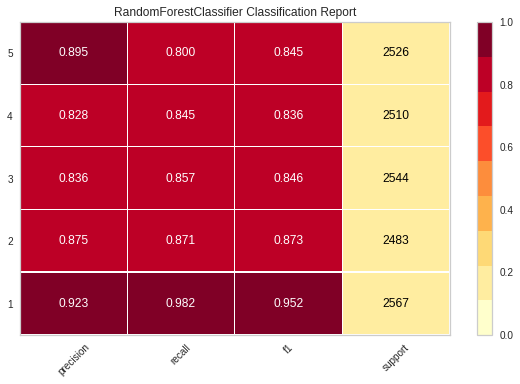

In [25]:
viz = ClassificationReport((RndFor), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

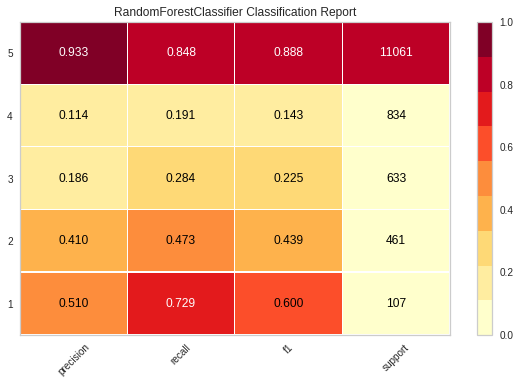

In [26]:
viz = ClassificationReport((RndFor), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

**Test Set**

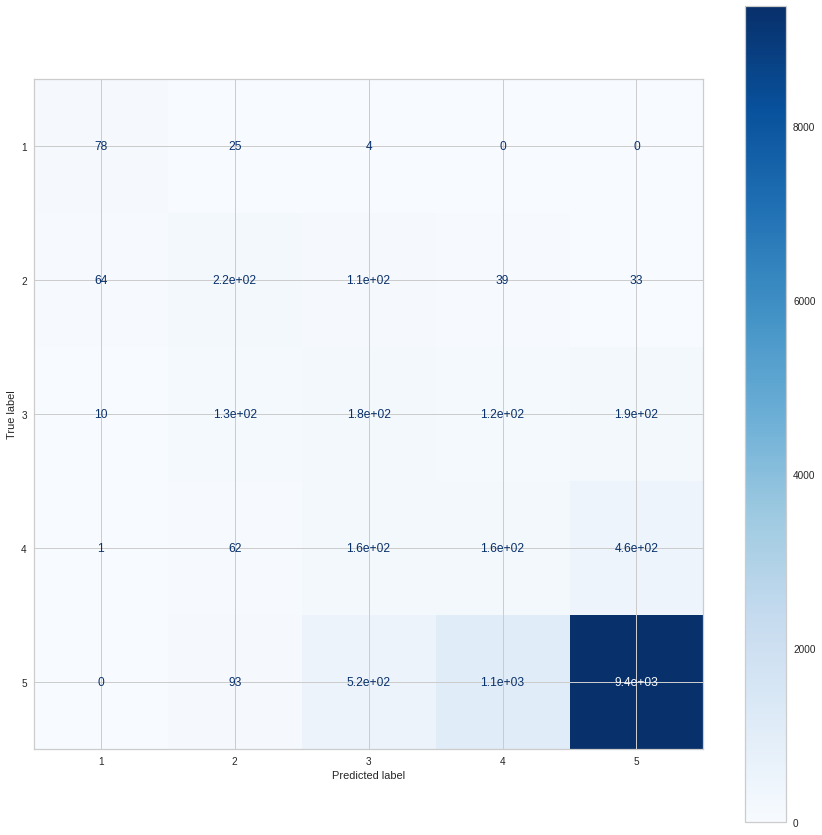

In [27]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(RndFor, X_test, y_test, cmap=plt.cm.Blues, ax=ax)

#### **GridSearch**

Since we are doing a multiclass evaluation, we will have to define our scoring strategy that aligns with our business objective. In our case, we are interested in the recall. We will use the "weighted" average to account for class imbalance which works by computing the average metrics where each class's score is weighted by its presence in the true data sample.  
[Scikit-Learn Reference](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring)

In [ ]:
"""
param_dict = {
    'class_weight':['balanced', 'balanced_subsample'],
    'n_estimators':range(100,500,50),
}
"""

In [ ]:
# Define scoring strategy
weighted_recall = make_scorer(recall_score, average='weighted')

In [ ]:
"""
RndForGrid = GridSearchCV(RndFor,
                          param_grid=param_dict,
                          cv=5,
                          scoring=weighted_recall,
                          verbose=1,
                          n_jobs=-1)
RndForGrid.fit(X_train, y_train)
"""

In [ ]:
#RndForGrid.best_params_

In [ ]:
# Store the best parameters
#RndForBest = RndForGrid.best_estimator_

#### **Best Tree From GridSearch**  
Best Parameters from GridSearch:  
*  n_estimators: 350  
*  class_weight: balanced
  
We stored our parameters under the RndForBest variable, but we will train our best model below so we don't have to run the GridSearch again.

In [28]:
RndForBest = RandomForestClassifier(n_estimators=350, class_weight='balanced', random_state=42)
RndForBest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

#### **Random Forest Evaluation**

In [10]:
pip install -U yellowbrick

     |████████████████████████████████| 276kB 4.2MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


##### **Classification Report**

In [29]:
from yellowbrick.classifier import ClassificationReport

**Validation Set**

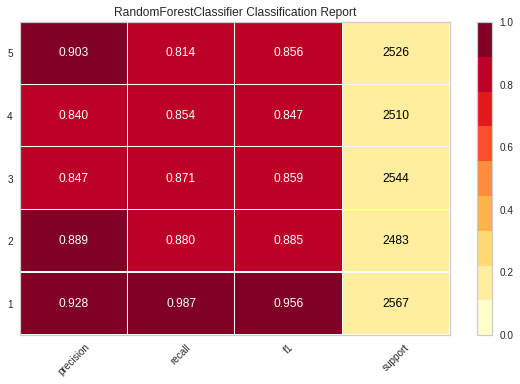

In [30]:
viz = ClassificationReport((RndForBest), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

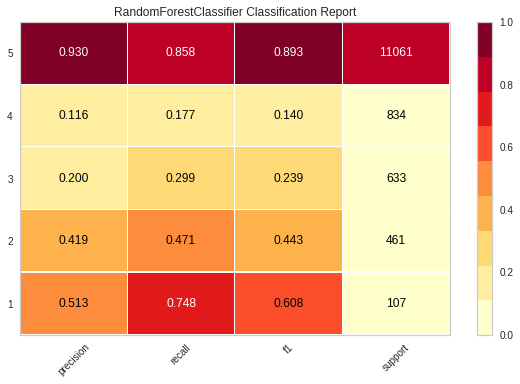

In [31]:
viz = ClassificationReport((RndForBest), per_class=True, support=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

##### **ROC-AUC Receiver Operating Characteristic**

In [ ]:
from yellowbrick.classifier import ROCAUC

**Validation Set**

In [ ]:
model = RndForBest
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)      
visualizer.score(X_val, y_val)
visualizer.show()

**Test Set**

In [ ]:
model = RndForBest
visualizer = ROCAUC(model)
visualizer.fit(X_train, y_train)      
visualizer.score(X_test, y_test)
visualizer.show()

##### **Precision-Recall Curves**

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve

**Validation Set**

In [ ]:
viz = PrecisionRecallCurve((RndForBest), classes=[1,2,3,4,5], per_class=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

In [ ]:
viz = PrecisionRecallCurve((RndForBest), classes=[1,2,3,4,5], per_class=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

##### **Class Prediction Error**  

In [ ]:
from yellowbrick.classifier import ClassPredictionError

**Validation Set**  
Had to convert y_val to 1D array

In [ ]:
y_val = y_val.to_numpy()

In [ ]:
y_val = y_val.flatten()

In [ ]:
y_val.ndim

In [ ]:
viz = ClassPredictionError((RndForBest), per_class=True)
viz.fit(X_train, y_train)
viz.score(X_val, y_val)
viz.show()

**Test Set**

In [ ]:
y_test = y_test.to_numpy()

In [ ]:
y_test = y_test.flatten()

In [ ]:
y_test.ndim

In [ ]:
viz = ClassPredictionError(RndForBest)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

##### **Confusion Matrix**  

In [32]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

**Validation Set**

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(RndForBest, X_val, y_val, cmap=plt.cm.Blues, ax=ax)

**Test Set**

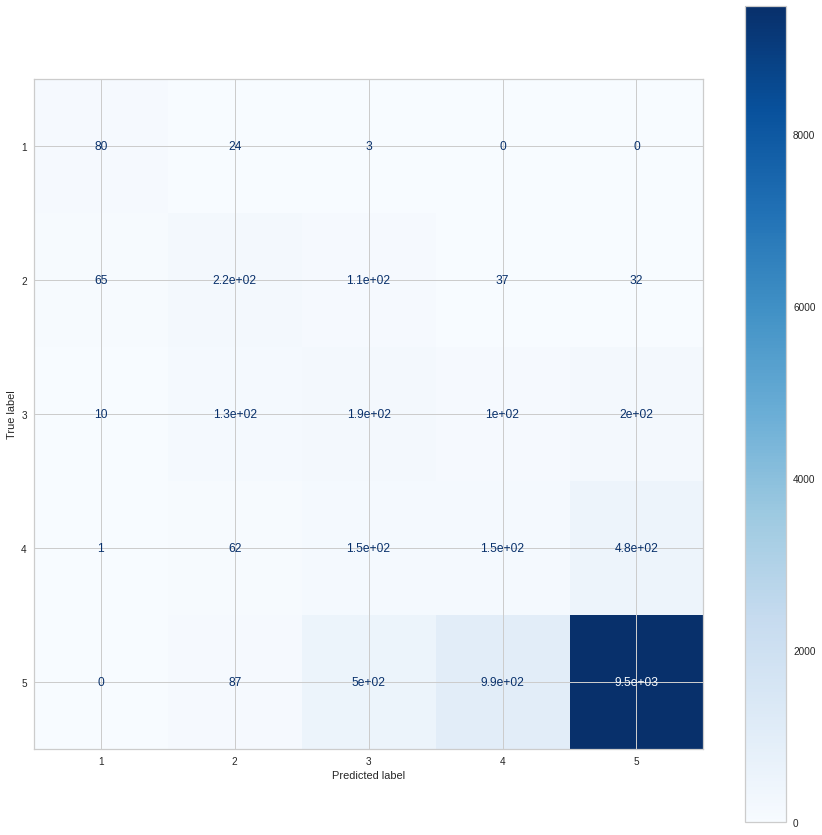

In [33]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(RndForBest, X_test, y_test, cmap=plt.cm.Blues, ax=ax)

## **Save Model**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import joblib

In [ ]:
model_save_name = '5_class_randomforest'
path = F"/content/gdrive/My Drive/GitHub/AMII/NASA_TurboFan_Data/FD001/Models/{model_save_name}"
joblib.dump(RndForBest, path)

In [ ]:
RndForBest = joblib.load('/content/gdrive/My Drive/GitHub/AMII/NASA_TurboFan_Data/FD001/Models/5_class_randomforest')

### **Results**  

When comparing our RandomForest model to the previous DecisionTree model, we observed:
*  8% increase in precision
*  6.5% decrease in recall
*  4.3% increase in F1
*  27% increase in Precision-Recall curve area 
   
When looking at the confusion matrices of the two models, we observed:
*  27 late predictions for the RandomForest
*  20 late predictions  for the DecisionTree
  
The model is overfitting the data, possibly due to the ADASYN implementation combined with the "weighted" average to account for class imbalance. Since the training data is already balanced with ADASYN the "weighted" average evaluation metric can not differentiate between classes. We will retrain a new random forest model using imbalanced training and test data.

## **Import Raw Data**

In [34]:
X_train = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/Unbalanced/X_train_scaled.csv')
y_train = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/Unbalanced/y_train.csv')

X_val = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/Unbalanced/X_val_scaled.csv')
y_val = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/Unbalanced/y_val.csv')

X_test = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/Unbalanced/X_test_scaled.csv')
y_test = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/Classification_Data/Unbalanced/y_test.csv')

FileNotFoundError: ignored

In [ ]:
train1_class = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/train1_new.csv')
test1_class = pd.read_csv('/content/cloned-repo/NASA_TurboFan_Data/FD001/test1.csv')

In [ ]:
sensor2keep = ['T24', 'T30', 'T50', 'P15', 'P30', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'w31', 'w32']
col2keep = ['Unit', 'T24', 'T30', 'T50', 'P15', 'P30', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'w31', 'w32', 'RUL']

In [ ]:
test1_class = test1_class[col2keep]

In [ ]:
for ii in range(len(train1_class)):

    curr_RUL = train1_class.loc[ii, 'RUL']

    if curr_RUL >= 0 and curr_RUL < 20:
        train1_class.loc[ii, 'RUL class'] = int(1)
    elif curr_RUL >= 20 and curr_RUL < 40:
        train1_class.loc[ii, 'RUL class'] = int(2)
    elif curr_RUL >= 40 and curr_RUL < 60:
        train1_class.loc[ii, 'RUL class'] = int(3)
    elif curr_RUL >= 60 and curr_RUL < 80:
        train1_class.loc[ii, 'RUL class'] = int(4)
    else:
        train1_class.loc[ii, 'RUL class'] = int(5)

In [ ]:
train1_class['RULclass'] = train1_class['RUL class'].astype(int)
train1_class.drop('RUL class', axis=1, inplace=True)

In [ ]:
for ii in range(len(test1_class)):

    curr_RUL = test1_class.loc[ii, 'RUL']

    if curr_RUL >= 0 and curr_RUL < 20:
        test1_class.loc[ii, 'RUL class'] = int(1)
    elif curr_RUL >= 20 and curr_RUL < 40:
        test1_class.loc[ii, 'RUL class'] = int(2)
    elif curr_RUL >= 40 and curr_RUL < 60:
        test1_class.loc[ii, 'RUL class'] = int(3)
    elif curr_RUL >= 60 and curr_RUL < 80:
        test1_class.loc[ii, 'RUL class'] = int(4)
    else:
        test1_class.loc[ii, 'RUL class'] = int(5)

In [ ]:
test1_class['RULclass'] = test1_class['RUL class'].astype(int)
test1_class.drop('RUL class', axis=1, inplace=True)

In [ ]:
train1_class.drop(['RUL', 'Unit', 'P15', 'NRc'], axis=1, inplace=True)

In [ ]:
train1_class.reset_index(drop=True, inplace=True)

In [ ]:
test1_class.drop(['RUL', 'Unit', 'P15', 'NRc'], axis=1, inplace=True)

In [ ]:
test1_class.reset_index(drop=True, inplace=True)

### **Stratified-Shuffle Split**

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(train1_class, train1_class['RULclass']):
  train = train1_class.loc[train_index]
  val = train1_class.loc[test_index]

In [ ]:
StratSplit = val['RULclass'].value_counts() / len(val)
Dist = train1_class['RULclass'].value_counts() / len(train1_class)

Create a DataFrame to compare the actual distribution of RULclass vs the distribution obtained form StratifiedShuffleSplit

In [ ]:
df_Compare = pd.DataFrame(columns = ['Stratified Split', 'Actual Distribution', 'Difference'])
df_Compare['Stratified Split'] = StratSplit
df_Compare['Actual Distribution'] = Dist
df_Compare['Difference'] = StratSplit - Dist
df_Compare

In [ ]:
print('Our training set is train with shape: ' + str(train.shape) + '\n'
'Our validation set is val with shape: ' + str(val.shape))

### **Preapre the Data for Machine Learning Algorithms**

In [ ]:
sensors = ['T24', 'T30', 'T50', 'P30', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'w31', 'w32']

In [ ]:
X_train = train.drop('RULclass', axis=1)
y_train = train['RULclass'].copy()

In [ ]:
X_val = val.drop('RULclass', axis=1)
y_val = val['RULclass'].copy()

In [ ]:
X_test = test1_class.drop('RULclass', axis=1)
y_test = test1_class['RULclass'].copy()

We will scale the data using MinMax scaler as that produced slightly better results from the previous notebook.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()

In [ ]:
X_train = scaler_minmax.fit_transform(X_train)
X_val = scaler_minmax.transform(X_val)
X_test = scaler_minmax.transform(X_test)

In [ ]:
X_train

### **Save Files**

In [ ]:
np.savetxt(fname='y_test.csv', delimiter=",", X=y_test)

In [ ]:
from google.colab import files
files.download('y_test.csv')

In [ ]:
test1.to_csv('test1.csv', index=False, header=True)
train1_new.to_csv('train1_new.csv', index=False, header=True)